In [1]:
#conda install -c pytorch torchvision

In [2]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np

import matplotlib.pyplot as plt

In [4]:
# Path to the folder containing images
image_folder = r'D:\AI-DATASETS\Images\dogs-cats\test'

In [5]:
# List all image files in the folder
all_images = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('png', 'jpg', 'jpeg'))]

In [6]:
len(all_images)

12500

In [7]:
# Select n random images
n = 100
random_images = random.sample(all_images, n)
plot_images   = random.sample(all_images, 10)

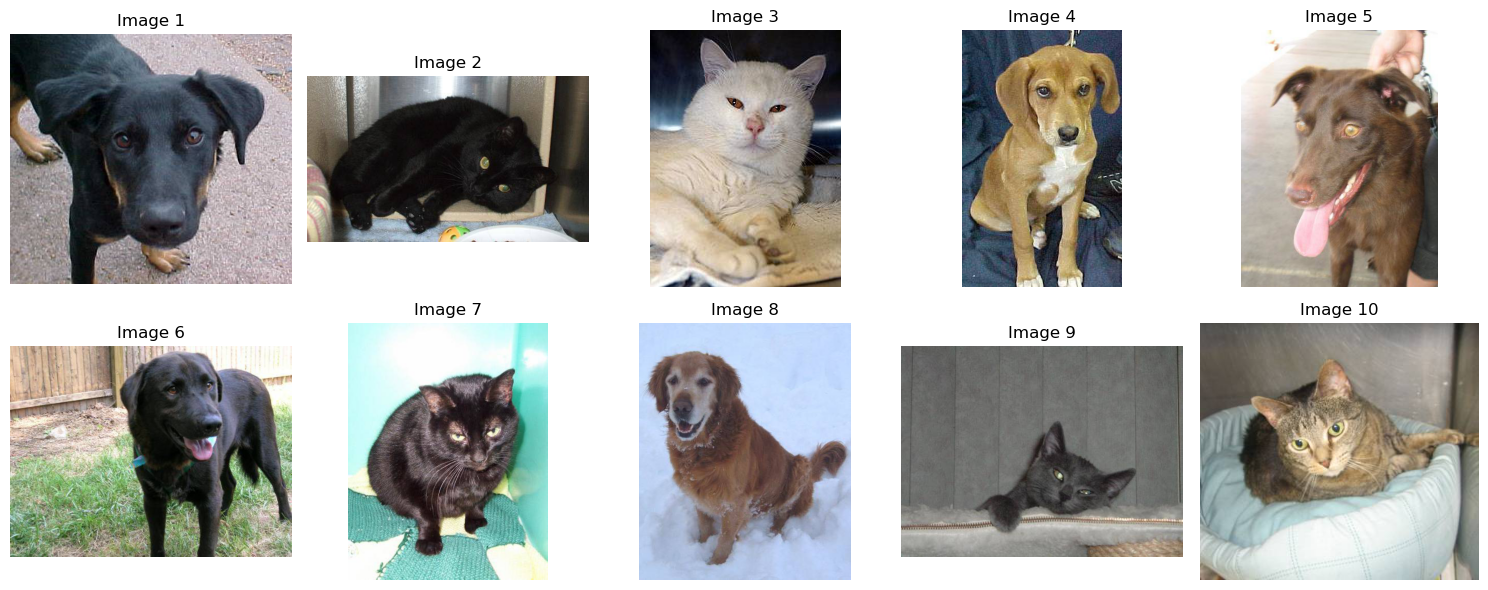

In [8]:
# Display random images in a grid
def display_images(image_paths, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    for i, ax in enumerate(axes.flatten()):
        if i < len(image_paths):
            img = Image.open(image_paths[i])
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"Image {i+1}")
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display the 10 random images
display_images(plot_images, rows=2, cols=5)

In [9]:
# Load and process these images
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize for InceptionV3
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [10]:
processed_images = []
for img_path in random_images:
    image = Image.open(img_path).convert("RGB")
    image = transform(image)
    processed_images.append(image)

In [11]:
# Stack images into a single tensor batch
import torch
batch = torch.stack(processed_images)
print(f"Processed a batch of shape: {batch.shape}")

Processed a batch of shape: torch.Size([100, 3, 299, 299])


In [12]:
# Load pre-trained InceptionV3 model
from torchvision.models import inception_v3
model = inception_v3(pretrained=True, transform_input=False)
model.eval()

D:\ANACONDA\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\ANACONDA\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

#### Class probability distribution

**Inception Score and Class Probability Distributions**

The Inception Score requires class probability distributions for each image in the dataset.

**InceptionV3 Model Output**

When you pass an image through the InceptionV3 model, it produces a vector of class probabilities for that image. This is essentially a probability distribution over the possible classes (e.g., 1000 possible classes if using the standard ImageNet model).

**Softmax on Model Output**

The output from InceptionV3 is passed through the softmax function to convert the raw logits into class probabilities.

```python
pred = model(batch).softmax(dim=-1).cpu().numpy()

In [13]:
if torch.cuda.is_available():
    print('Cuda available')
    model = model.cuda()

In [14]:
# Get predictions for the batch
# takes about 1 min for 100 images prediction
with torch.no_grad():
    preds = model(batch).softmax(dim=-1).cpu().numpy()

In [15]:
preds

array([[5.62305650e-05, 9.80262339e-05, 2.02578842e-04, ...,
        9.00818050e-05, 7.48337552e-05, 3.09940602e-04],
       [6.29519345e-05, 3.26773152e-05, 3.30884686e-05, ...,
        3.10029172e-05, 9.47446024e-05, 6.92971953e-05],
       [2.34621883e-04, 1.80287476e-04, 9.99667536e-05, ...,
        1.81738054e-04, 1.63618461e-04, 2.56232335e-04],
       ...,
       [8.09670091e-05, 3.12013362e-05, 7.28003943e-05, ...,
        5.81390959e-05, 2.20747635e-04, 1.87321071e-04],
       [1.33060739e-05, 1.10047795e-05, 5.65704977e-06, ...,
        1.49551424e-05, 2.98056821e-05, 2.16700173e-05],
       [5.00407950e-05, 5.67932148e-05, 1.08936278e-04, ...,
        7.54620560e-05, 5.81037239e-05, 8.14906671e-05]], dtype=float32)

In [16]:
preds.shape

(100, 1000)

#### function to compute IS

In [22]:
def compute_inception_score(preds, splits=5):
    split_scores = []

    for k in range(splits):
        
        #              0    100            // 5      : 1       *  100            // 5
        part   = preds[k * (preds.shape[0] // splits): (k + 1) * (preds.shape[0] // splits), :]

        # marginal prob distribution, returns 1 agg row for all the images in the part
        p_y    = np.mean(part, axis=0)

        # here we are trying to compare the individual image probabilities with the marginal
        # prob -> to see if the individual image is really different compare to the overall prob dist
        # if the images prob align well with the marginal prob --> the log-diff will be small
        # and vice versa

        # (np.log(part) - np.log(p_y[None, :]) - what it returns
        # shape of the above will same as 'part'e.g. 20 x 1000

        # why we are multiplying with 'part'?
        # part -> 20x1000 and (np.log(part) - np.log(p_y[None, :]) -> 20x1000
        # outcome of the above will also be 20x1000

        # part -> individual prob
        # (np.log(part) - np.log(p_y[None, :]) -> difference

        # if both are high -> you get higher IS
        # otherwise IS is low
        scores = part * (np.log(part) - np.log(p_y[None, :]))

        split_scores.append(np.exp(np.mean(np.sum(scores, axis=1))))

    return np.mean(split_scores), np.std(split_scores)

In [17]:
part_test = np.array([ [0.82143103, 0.53332635, 0.04452666, 0.95544713, 0.4988346 ],
                       [0.09269164, 0.14914795, 0.89790919, 0.03787269, 0.31008148],
                       [0.372053  , 0.68974016, 0.67451996, 0.74447484, 0.66882661],
                       [0.71359962, 0.27169305, 0.23318031, 0.06823716, 0.07142102],
                       [0.00997521, 0.71284004, 0.97927563, 0.39888987, 0.41953201]])

In [18]:
p_y_test = np.mean(part_test, axis=0)
p_y_test

array([0.4019501 , 0.47134951, 0.56588235, 0.44098434, 0.39373914])

In [19]:
p_y_test[None, :]

array([[0.4019501 , 0.47134951, 0.56588235, 0.44098434, 0.39373914]])

**Predicted Probability Distribution for Each Image (part):**
- For each generated image (or sample), a probability distribution over classes is computed. This distribution reflects the model's confidence about which class the image belongs to. For example, in a classification setting with 5 classes, the predicted probability for each class might look like:

**Marginal Distribution (p_y):**
- The marginal distribution represents the average probability of each class across all images (or samples). It tells you, in general, how likely each class is, regardless of which specific image you’re looking at. For example, across all generated images, the marginal distribution might look like:

In [23]:
mean_score, std_score = compute_inception_score(preds)
print(f"Inception Score: {mean_score:.4f} ± {std_score:.4f}")

Inception Score: 5.9941 ± 1.1770


#### Inception Score Interpretation

**Mean Score (1.7398):**
- A higher mean score indicates better quality and diversity in the images.
- Scores closer to 1 suggest lower diversity or that the images lack meaningful content.
- For high-quality and diverse image datasets (e.g., ImageNet), the score is typically much higher (e.g., 10–12+).

**Standard Deviation (± 0.1243):**
- Reflects variability in the scores across splits.
- A lower standard deviation indicates consistent quality and diversity.
